In [19]:
import pandas as pd
import mysql.connector
import os
import logging
from time import sleep

# Configure logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')
]

# Folder containing the CSV files
folder_path = r'D:\Eco_python_sql\data_set'

def get_sql_type(dtype):
    """Map pandas dtypes to MySQL data types."""
    if pd.api.types.is_integer_dtype(dtype):
        return 'BIGINT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'DOUBLE'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'TINYINT(1)'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    elif dtype.name == 'object':
        return 'VARCHAR(255)'
    else:
        return 'TEXT'

def create_connection(retries=3, delay=5):
    """Create a connection to the MySQL database with retry mechanism."""
    for attempt in range(retries):
        try:
            return mysql.connector.connect(
                host='127.0.0.1',
                user='amar',
                password='amar',
                database='ecommerce'
            )
        except mysql.connector.Error as err:
            logging.error(f"Connection attempt {attempt + 1} failed: {err}")
            if attempt < retries - 1:
                sleep(delay)
            else:
                raise

def validate_table_schema(cursor, table_name, df):
    """Validate the table schema matches the DataFrame."""
    cursor.execute(f"DESCRIBE `{table_name}`")
    table_schema = {row[0]: row[1] for row in cursor.fetchall()}
    df_schema = {col: get_sql_type(dtype) for col, dtype in df.dtypes.items()}
    
    for col, sql_type in df_schema.items():
        if col not in table_schema or sql_type not in table_schema[col]:
            logging.warning(f"Schema mismatch for `{table_name}`: `{col}` expected `{sql_type}`, found `{table_schema.get(col, 'MISSING')}`")

# Main execution
try:
    conn = create_connection()
    cursor = conn.cursor()
    logging.info("Database connection established.")

    for csv_file, table_name in csv_files:
        file_path = os.path.join(folder_path, csv_file)
        
        # Check if the file exists
        if not os.path.exists(file_path):
            logging.warning(f"File not found: {file_path}")
            continue

        # Read the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)
        df = df.where(pd.notnull(df), None)
        df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

        # Generate CREATE TABLE statement
        columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
        create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
        
        try:
            cursor.execute(create_table_query)
            validate_table_schema(cursor, table_name, df)

            # Insert data in batches
            batch_size = 1000
            insert_query = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(df.columns))})"
            data = [tuple(None if pd.isna(x) else x for x in row) for _, row in df.iterrows()]

            for i in range(0, len(data), batch_size):
                batch = data[i:i + batch_size]
                cursor.executemany(insert_query, batch)
                logging.info(f"Inserted batch {i // batch_size + 1} into `{table_name}`.")

            conn.commit()
            logging.info(f"Table `{table_name}` processed successfully.")
        except mysql.connector.Error as err:
            logging.error(f"Error with table `{table_name}`: {err}")
            conn.rollback()
except mysql.connector.Error as conn_err:
    logging.critical(f"Database connection error: {conn_err}")
finally:
    if 'cursor' in locals() and cursor:
        cursor.close()
    if 'conn' in locals() and conn:
        conn.close()
    logging.info("Database connection closed.")


2024-12-24 02:51:11,913 - INFO - Database connection established.
2024-12-24 02:51:12,350 - WARNING - Schema mismatch for `customers`: `customer_id` expected `VARCHAR(255)`, found `varchar(255)`
2024-12-24 02:51:12,351 - WARNING - Schema mismatch for `customers`: `customer_unique_id` expected `VARCHAR(255)`, found `varchar(255)`
2024-12-24 02:51:12,352 - WARNING - Schema mismatch for `customers`: `customer_zip_code_prefix` expected `BIGINT`, found `bigint`
2024-12-24 02:51:12,352 - WARNING - Schema mismatch for `customers`: `customer_city` expected `VARCHAR(255)`, found `varchar(255)`
2024-12-24 02:51:12,353 - WARNING - Schema mismatch for `customers`: `customer_state` expected `VARCHAR(255)`, found `varchar(255)`
2024-12-24 02:51:18,058 - INFO - Inserted batch 1 into `customers`.
2024-12-24 02:51:18,119 - INFO - Inserted batch 2 into `customers`.
2024-12-24 02:51:18,191 - INFO - Inserted batch 3 into `customers`.
2024-12-24 02:51:18,258 - INFO - Inserted batch 4 into `customers`.
2024

Transfer data from CSV to MySQL through python code and now performing some SQL query

In [35]:
        import mysql.connector

try:
    # Connect to MySQL server without specifying a database
    conn = mysql.connector.connect(
        host='127.0.0.1',
        user='amar',
        password='amar'
    )
    cursor = conn.cursor()

    # Create the database if it doesn't exist
    cursor.execute("CREATE DATABASE IF NOT EXISTS ecommerce")
    conn.commit()

    # Reconnect to the newly created database
    conn = mysql.connector.connect(
        host='127.0.0.1',
        user='amar',
        password='amar',
        database='ecommerce'
    )
    print("Database connected successfully!")

except mysql.connector.Error as err:
    print(f"Error: {err}")


Database connected successfully!


In [49]:
 import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect(
        host='127.0.0.1',
        user='amar',
        password='amar',
        database='ecommerce'
    )
 cur = db.cursor()


List all unique cities where customers are located.

In [51]:
query = """ select distinct customer_city from customers"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


Count the number of orders placed in 2017.

In [13]:
query = """ select count(order_id) from orders 
             where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
"Total orders placed in 2017",data[0][0]

('Total orders placed in 2017', 45101)


Find the total sales per category.

In [17]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
order by sales desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Sales"])
df

,Category,Sales
0,BED TABLE BATH,1712553.67
1,HEALTH BEAUTY,1657373.12
2,COMPUTER ACCESSORIES,1585330.45
3,FURNITURE DECORATION,1430176.39
4,WATCHES PRESENT,1429216.68
...,...,...
69,PC GAMER,2174.43
70,HOUSE COMFORT 2,1710.54
71,CDS MUSIC DVDS,1199.43
72,FASHION CHILDREN'S CLOTHING,785.67


Calculate the percentage of orders that were paid in installments.

In [10]:
query = """ select (sum(case when payment_installments >= 1 
then 1 else 0 end))/count(*)*100 from payments
"""

cur.execute(query)

data = cur.fetchall()
data

[(Decimal('99.9981'),)]

Count the number of customers from each state.

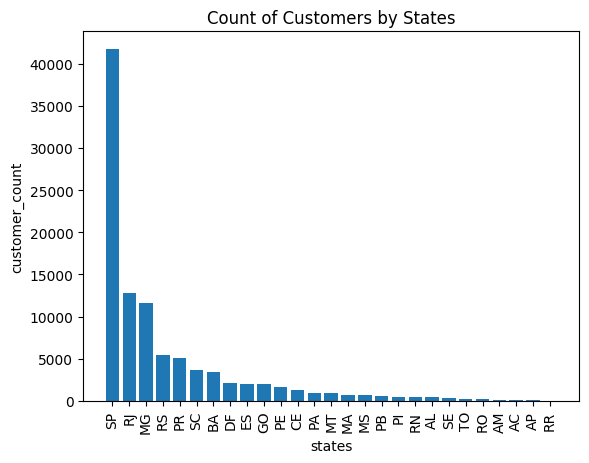

In [11]:

query = """ select customer_state ,count(customer_id)
from customers group by customer_state
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_count" ])
df = df.sort_values(by = "customer_count", ascending= False)


plt.bar(df["state"], df["customer_count"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of Customers by States")
plt.show()

Calculate the number of orders per month in 2018.

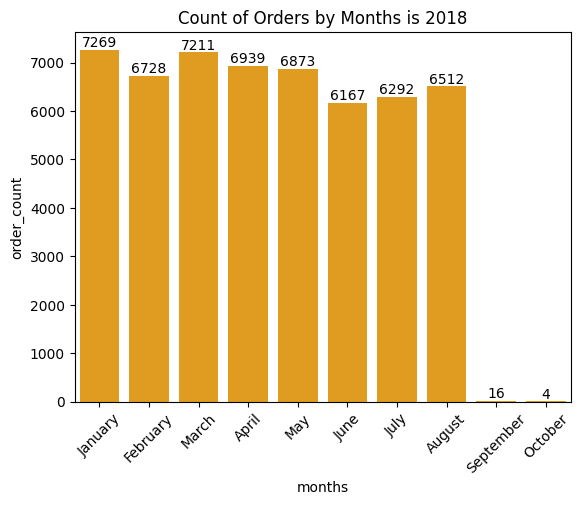

In [12]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) order_count
from orders where year(order_purchase_timestamp) = 2018
group by months
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
o = ["January", "February","March","April","May","June","July","August","September","October"]

ax = sns.barplot(x = df["months"],y =  df["order_count"], data = df, order = o, color = "orange")
plt.xticks(rotation = 45)
ax.bar_label(ax.containers[0])
plt.title("Count of Orders by Months is 2018")

plt.show()

Find the average number of products per order, grouped by customer city.

In [13]:
query = """with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, round(avg(count_per_order.oc),2) average_orders
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_orders desc
"""

cur.execute(query)

data = cur.fetchall()
df = pd.DataFrame(data,columns = ["customer city", "average products/order"])
df.head(10)

,customer city,average products/order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


Calculate the percentage of total revenue contributed by each product category.

In [31]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value)/(SELECT sum(payment_value) FROM ecommerce.payments)*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id = order_items.order_id
group by category
order by sales desc
"""

cur.execute(query)

data = cur.fetchall()

df = pd.DataFrame(data, columns = ["Category", "Percentage_distribution"])
df.head()

,Category,Percentage_distribution
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


Identify the correlation between product price and the number of times a product has been purchased.

In [61]:
cur = db.cursor()
query = """select products.product_category, 
count(order_items.product_id),
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Category", "order_count","price"])
df.head()

arr1 = df["order_count"]
arr2 = df["price"]

a = np.corrcoef([arr1,arr2])
print("the correlation is", a[0][-1])

the correlation is -0.10631514167157563


Calculate the total revenue generated by each seller, and rank them by revenue.

In [69]:
query = """select  *, dense_rank() over(order by revenue desc) as rn from 
(select seller_id, round(sum(payment_value),2) as revenue 
from order_items join payments  on order_items.order_id = payments.order_id
group by seller_id
order by revenue desc) as a;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["Seller ID", "Revenue","Rank"])
df.head()

,Seller ID,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5


Calculate the moving average of order values for each customer over their order history.

In [21]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp, 
payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["Customer_ID","Order Purchase Timestamp","Payments","Moving Average"])
df

,Customer_ID,Order Purchase Timestamp,Payments,Moving Average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,0.64,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


 Calculate the cumulative sales per month for each year.

In [55]:

query = """ select Years, Months , Payments, round(sum(payments) over( order by years ,months),2) as Cummulative_sales from
 (select Year(order_purchase_timestamp) as Years, month(order_purchase_timestamp) as Months, round(sum(payment_value),2) as  Payments from
 orders join payments on orders.order_id = payments.order_id
 group by  years, Months
 order by years, Months 
 )as a ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns =["Years","Months","Sales","Cummulative Sales"])
df

,Years,Months,Sales,Cummulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


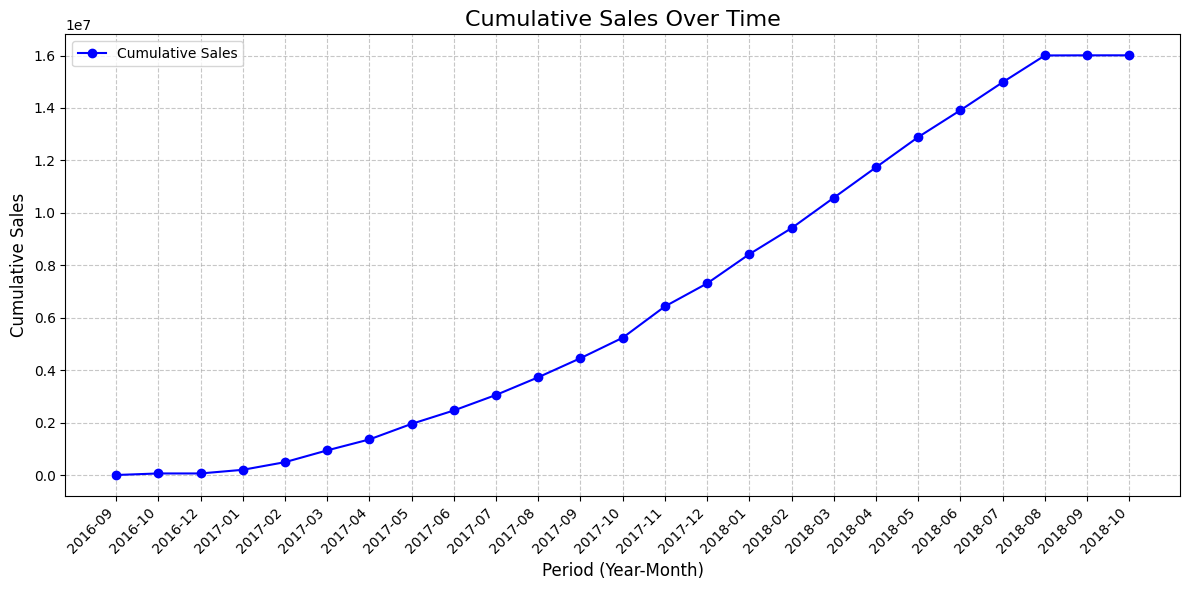

In [57]:
import matplotlib.pyplot as plt
import pandas as pd

# Assuming `df` is already created from the SQL query
# df = pd.DataFrame(data, columns=["Years", "Months", "Sales", "Cummulative Sales"])

# Combine 'Years' and 'Months' for better labeling on the x-axis
df["Period"] = df["Years"].astype(str) + "-" + df["Months"].astype(str).str.zfill(2)

# Plot the Cumulative Sales as a Line Chart
plt.figure(figsize=(12, 6))
plt.plot(df["Period"], df["Cummulative Sales"], marker='o', linestyle='-', color='blue', label="Cumulative Sales")

# Add chart labels and title
plt.xlabel("Period (Year-Month)", fontsize=12)
plt.ylabel("Cumulative Sales", fontsize=12)
plt.title("Cumulative Sales Over Time", fontsize=16)
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.grid(visible=True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()

# Show the plot
plt.show()


Calculate the year-over-year growth rate of total sales.

In [43]:
query = """with a as(select year(orders.order_purchase_timestamp) as years,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, ((payment - lag(payment, 1) over(order by years))/
lag(payment, 1) over(order by years)) * 100 from a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "Year by Year % growth"])
df

,Years,Year by Year % growth
0,2016,NaN
1,2017,12112.703761
2,2018,20.000924


Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.

In [37]:
query = """with a as (select customers.customer_id,
min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.customer_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id
and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < 
date_add(first_order, interval 6 month)
group by a.customer_id) 

select 100 * (count( distinct a.customer_id)/ count(distinct b.customer_id)) 
from a left join b 
on a.customer_id = b.customer_id ;"""

cur.execute(query)
data = cur.fetchall()

data  #output null because no repeated customer

[(None,)]

Identify the top 3 customers who spent the most money in each year.

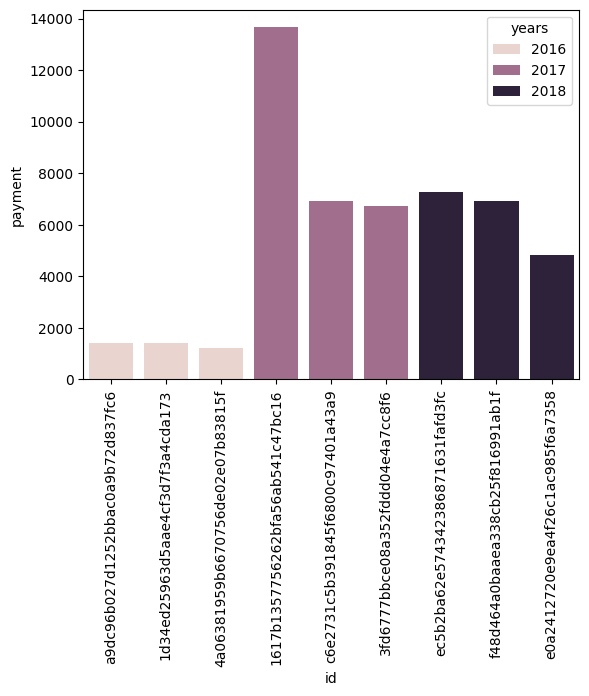

In [41]:

query = """select years, customer_id, payment, d_rank
from
(select year(orders.order_purchase_timestamp) years,
orders.customer_id,
sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp)
order by sum(payments.payment_value) desc) d_rank
from orders join payments 
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp),
orders.customer_id) as a
where d_rank <= 3 ;"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years","id","payment","rank"])
sns.barplot(x = "id", y = "payment", data = df, hue = "years")
plt.xticks(rotation = 90)
plt.show()